# Sequence to Sequence
...

## Implementation
This implementation of Sequence to Sequence Model is based on LSTM and trained on custom dataset.

**Dimensions** 
- `b` : batch size
- `si` : input sequence length
- `st` : target sequence length
- `h` : hidden vector size
- `wv` : embedding word vector size
- `v` : vocabulary size
### imports

In [1]:
#%%
# data
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import trange
import matplotlib.pyplot as plt
import os
import numpy as np

from toy_data.ncutils import NumCharCorpus

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\PC\anaconda3\envs\diffuser\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preperation (Custom Dataset, DataLoader)

In [2]:
ncc = NumCharCorpus()
ncc.fliplr_x()
vocab_size = ncc.vocab_size
wv_size = 16
hidden_size = 100
batch_size = 64

ds_train = ncc.get_dataset(train=True)
train_loader = DataLoader(ds_train, batch_size=batch_size)
ds_test = ncc.get_dataset(train=False)
test_loader = DataLoader(ds_test, batch_size=batch_size)

### Seq2seq Model
#### Encoder
input|<span style="font-weight:normal"> Indexed Sequence Data `(torch.tensor: (b, si, 1))`</span>
|:-------:|:---------------------------------------------------------------------------------|
**output**| (hidden state, cell state) `(Tuple[torch.tensor]: ((b, h), (b, h)))`

`Encoder` is an LSTM model with embedding layer infront. It takes in sequence datas(expressed as indexes in a vocabulary) and outputs hidden states of LSTM.

- `nn.Embedding(vocab_size, wv_size)` layer is used when input must be a form of one-hot. Instead of feeding one-hot to a `nn.Linear` layer, `nn.Embedding` takes in an index and returns a vector(or embedding). The embedding has `require_grad=True` so it can update the embedding. layer is essentially indexes a linear layer, where it takes an index number and returns a embedding. `nn.Embedding` layer is essentially indexes a linear layer.

In [3]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, wv_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, wv_size)
        self.embed.weight.data /= 100
        self.rnn = nn.LSTM(wv_size, hidden_size, batch_first=True)
        
    def forward(self, x):
        x = self.embed(x)
        _, h = self.rnn(x)
        return h

#### Decoder
`Decoder` is an LSTM model with embedding layer infront. It takes in sequence datas(expressed as indexes in a vocabulary) with (hidden state, cell state) from `Encoder` as tuple and outputs one-hot Sequence. Decoder had different pipeline for *training* and *inference*, thus we use torch standard of `forward` method for training and custom `generate` method for inference.

- `forward`: In training, we want to force correct seqence for the input of LSTM. Therefore we input target sequence data and the hidden state of the `Encoder`.

    input|<span style="font-weight:normal">- Indexed Sequence Data `(torch.tensor: (b, st, 1))`,<br />- (hidden state, cell state) `(Tuple[torch.tensor]: ((b, h), (b, h)))`</span>
    |:-------:|:---------------------------------------------------------------------------------|
    **output**| Output one-hot Sequence `(torch.tensor : (b, v))`
<br />

- `generate` :  At inference, since we want the Decoder to generate from the hidden states of the `Encoder` without giving the target sequence, it only takes in the starting index and the hidden states and autoregressively generates output sequence with length=`sample_size`

    input|<span style="font-weight:normal">- (hidden state, cell state) `(Tuple[torch.tensor]: ((b, h), (b, h)))`<br />- Starting index `(torch.tensor: (b, 1, 1))`,<br />- sample_size `(int: st)`</span>
    |:-------:|:---------------------------------------------------------------------------------|
    **output**| Generated Indexed Sequence `(torch.tensor : (b, sample_size, 1))`

    Since `nn.LSTM` must take in the full sequence and outputs a sequence with the same length, in order to generate a sequence autoregressively, we **need to loop on `nn.LSTM` and feed the input sequence with length of 1 repeatedly**.

In [4]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, wv_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, wv_size)
        self.embed.weight.data /= 100
        self.rnn = nn.LSTM(wv_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, h):
        x = self.embed(x)
        x, _ = self.rnn(x, h)
        x = self.linear(x)
        return x
    
    def generate(self, h, start_id, sample_size):
        x, xs = start_id, []            # x: (b, 1, 1)
        for _ in range(sample_size):
            x = self.embed(x)           # x: (b, 1, wv)
            x, h = self.rnn(x, h)       # x: (b, 1, h)
            x = self.linear(x)          # x: (b, 1, v)
            
            x = torch.argmax(x, dim=2)  # x: (b, 1, 1)
            xs.append(x.detach())       # xs: [(b, 1, 1)]*st
        xs = torch.stack(xs, dim=1)     # xs: (b, st, 1, 1)
        return xs[...,0] # remove dummy sequence length 1 we had earlier, xs: (b, st, 1)

#### Seq2seq
: `Seq2seq` module wraps `Encoder` and `Decoder`. It feeds the final hidden states of the `Encoder` to the `Decoder` in feed-forward. Because `Decoder` have different pipeline in *training* and *inference*, `Seq2seq` also use torch standard of `forward` method for training and custom `inference` method for inference.

- `forward`: In training, we input target sequence data and the hidden state of the `Encoder` to the `Decoder`.

    input|<span style="font-weight:normal">- Input Indexed Sequence Data `(torch.tensor: (b, si, 1))`<br />- Target Indexed Sequence Data `(torch.tensor: (b, st, 1)`</span>
    |:-------:|:---------------------------------------------------------------------------------|
    **output**|- Output one-hot Sequence `(torch.tensor : (b, v))`<br />- Target Indexed Sequence Data  `(torch.tensor: (b, st, 1)`
<br />

- `inference` :  At inference, we input the starting index, the final hidden states of the `Encoder` and the `sample_size` to the `Decoder.generate` method.

    input|<span style="font-weight:normal">- Input Indexed Sequence Data `(torch.tensor: (b, si, 1))`<br />- Target Indexed Sequence Data `(torch.tensor: (b, st, 1)`<br />- sample_size `(int: st)`</span>
    |:-------:|:---------------------------------------------------------------------------------|
    **output**|- Generated Indexed Sequence `(torch.tensor : (b, st, 1))`<br />- Target Indexed Sequence Data  `(torch.tensor: (b, st, 1)`

In [5]:
class Seq2seq(nn.Module):
    def __init__(self, vocab_size, wv_size, hidden_size):
        super().__init__()
        self.encoder = Encoder(vocab_size, wv_size, hidden_size)
        self.decoder = Decoder(vocab_size, wv_size, hidden_size)
        
    def forward(self, x, t):
        h = self.encoder(x)
        y = self.decoder(t[:, :-1], h)
        return y, t[:, 1:]
    
    def inference(self, x, t, sample_size):
        h = self.encoder(x)
        y = self.decoder.generate(h, t[:,:1], sample_size)
        return y, t[:, 1:]

#### Declare model

In [6]:
model = Seq2seq(vocab_size, wv_size, hidden_size).to("cuda")

### Peeky Seq2seq Model
#### Peeky Decoder
`PeekyDecoder` is similar to normal Seq2seq `Decoder` but the hidden states of the `Encoder` is concatenated to the `nn.LSTM` input and `nn.Linear` input. Therefore we slightly modify the `forward` and `generate` method of `Decoder` class.

In [16]:
class PeekyDecoder(nn.Module):
    def __init__(self, vocab_size, wv_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, wv_size)
        self.embed.weight.data /= 100
        self.rnn = nn.LSTM(wv_size+hidden_size*2, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size*3, vocab_size)
    
    def forward(self, x, h):
        x = self.embed(x)
        *hh, = map(lambda x: torch.permute(x, (1, 0, 2)).repeat(1, 4, 1), h)
        x, _ = self.rnn(torch.cat((x, *hh), dim=-1), h)
        x = self.linear(torch.cat((x, *hh), dim=-1))
        return x
    
    def generate(self, h, start_id, sample_size):
        x, xs = start_id, []
        *hh, = map(lambda x: torch.permute(x, (1, 0, 2)), h)
        for _ in range(sample_size):
            x = self.embed(x)
            x, h = self.rnn(torch.cat((x, *hh), dim=-1), h)
            x = self.linear(torch.cat((x, *hh), dim=-1))
            x = torch.argmax(x, dim=2)
            xs.append(x.detach())
        return torch.stack(xs, dim=1)[...,0]

#### PeekySeq2seq
: `PeekySeq2seq` inherits `Seq2seq` and overloads `Decoder` to `PeekyDecoder`.

In [17]:
class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wv_size, hidden_size):
        super().__init__(vocab_size, wv_size, hidden_size)
        self.decoder = PeekyDecoder(vocab_size, wv_size, hidden_size)

#### Declare model

In [ ]:
peekyModel = PeekySeq2seq(vocab_size, wv_size, hidden_size).to("cuda")

### Training Setup
#### Evaluating seq2seq
We first define a function for evaluting the performance of our Seq2seq model by the accuracy of the output.

In [7]:
def eval_seq2seq(model, test_loader, device):
    acc = tot = 0
    for x, t in test_loader:
        x, t = x.to(device), t.to(device)
        y, dts = model.inference(x, t, 4)
        y, dts = y.flatten(), dts.flatten()
        
        tot += y.shape[0]
        acc += torch.sum(y==dts).item()
    acc /= tot
    return acc

#### Trainer Function
We also make training process as a funtion to use it multiple times for various Seq2seq defined models. Both training setup and training loop is contained in this function.

In [10]:
def trainer(model, train_loader, test_loader):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    lossfn = nn.CrossEntropyLoss()
    loss = []
    accuracy = []

    model.train()
    pbar = trange(30, desc='epoch: 1')
    for epoch in pbar:
        aloss = 0
        for x, t in train_loader: 
            x, t = x.to("cuda"), t.to("cuda")
            y, dts = model(x, t)
            
            optimizer.zero_grad()
            L = lossfn(y.reshape(-1, vocab_size), dts.flatten()) 
            L.backward()
            
            optimizer.step()
            aloss += L.item()
        loss.append(aloss / x.shape[0])
        accuracy.append(eval_seq2seq(model, test_loader, "cuda"))
        pbar.set_description(f'epoch: {epoch+1}, loss: {loss[-1]}, acc: {accuracy[-1]}')
        
    return loss, accuracy

### Training
#### Training Seq2Seq

In [15]:
loss, accuracy = trainer(model, train_loader, test_loader)

epoch: 30, loss: 2.24320915233875, acc: 0.99715: 100%|██████████| 30/30 [00:38<00:00,  1.29s/it]  


#### Loss and Accuracy curve

(Text(0.5, 0, 'epoch'), None, (0.0, 1.0))

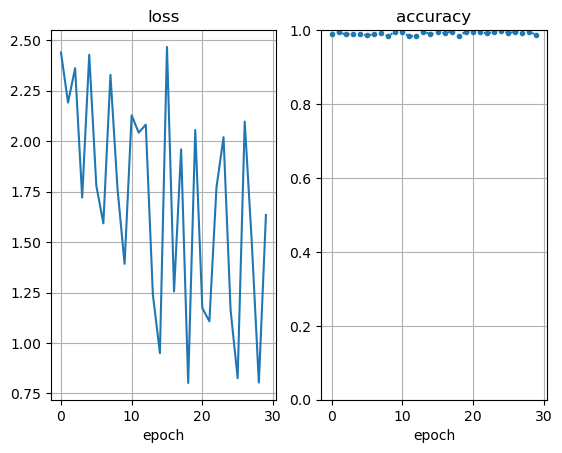

In [14]:
plt.subplot(121)
plt.plot(loss), plt.title("loss")
plt.xlabel("epoch"), plt.grid()

plt.subplot(122)
plt.plot(accuracy, '.:'), plt.title("accuracy")
plt.xlabel("epoch"), plt.grid(), plt.ylim(0, 1)

#### Training PeekySeq2Seq

In [21]:
loss, accuracy = trainer(peekyModel, train_loader, test_loader)

epoch: 30, loss: 1.588670204153459, acc: 0.9978: 100%|██████████| 30/30 [00:41<00:00,  1.37s/it]  


#### Loss and Accuracy curve

(Text(0.5, 0, 'epoch'), None, (0.0, 1.0))

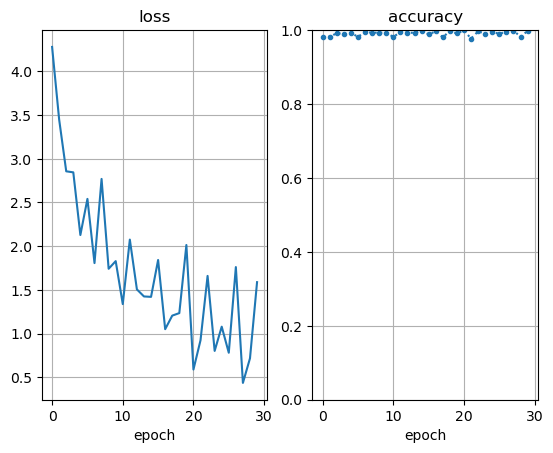

In [22]:
plt.subplot(121)
plt.plot(loss), plt.title("loss")
plt.xlabel("epoch"), plt.grid()

plt.subplot(122)
plt.plot(accuracy, '.:'), plt.title("accuracy")
plt.xlabel("epoch"), plt.grid(), plt.ylim(0, 1)